In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

#MPI
from schwimmbad import MPIPool

#General packages
import numpy as np
import emcee
import matplotlib.pyplot as plt

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.constants import G, M_sun, c
import astropy.units as u

#Autolens Model packages
import autolens as al
import autolens.plot as aplt

#My Emcee for Pyautolens
import My_Autolens

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_5/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

## Models inicialization

"""
    To inicialize the model, we set some random values for the parameters. But it's only necessary for initialize the model. During the non-linear search, this values will be updated constantly until the best fit.
"""  
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
ml     = 7.00                                                          #mass to light ratio
r_s    = 11.5                                                          #scale radius [arcsec]
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear


#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile
mass_profile = al.mp.MGE()    #Mass class

ell_comps    = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW         = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps ,scale_radius=r_s) #Analytical eNFW profile


#Components
#Do not include MGE DM component here
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh) 
mass_profile.Analytic_Model(eNFW)  #Include Analytical NFW

In [43]:
#Model
emcee_model = My_Autolens.Models(mass_profile=mass_profile, masked_imaging=masked_image, quiet=True)
emcee_model.include_DM_analytical(eNFW)
emcee_model(p0)

{'ml': 7.0, 'kappa_s': 0.075, 'qDM': 0.85, 'log_mbh': 9.0, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}


169.12855074412118

In [39]:
#Simulation inputs
# ml, kappa_s, qDM, log_mbh, mag_shear, phi_shear, gamma = pars
p0 = np.array([ml, kappa_, qobs_dm[0], np.log10(mbh), 0.02, 88., 1.0])

In [40]:
from scipy.optimize import minimize

def log_posterior(p0):
    value = emcee_model(p0)
    print(value)
    if np.isfinite(value):
        return value
    else:
        return -1e100

nll = lambda *args: log_posterior(*args)


ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}


{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.08
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.02
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.08
sca

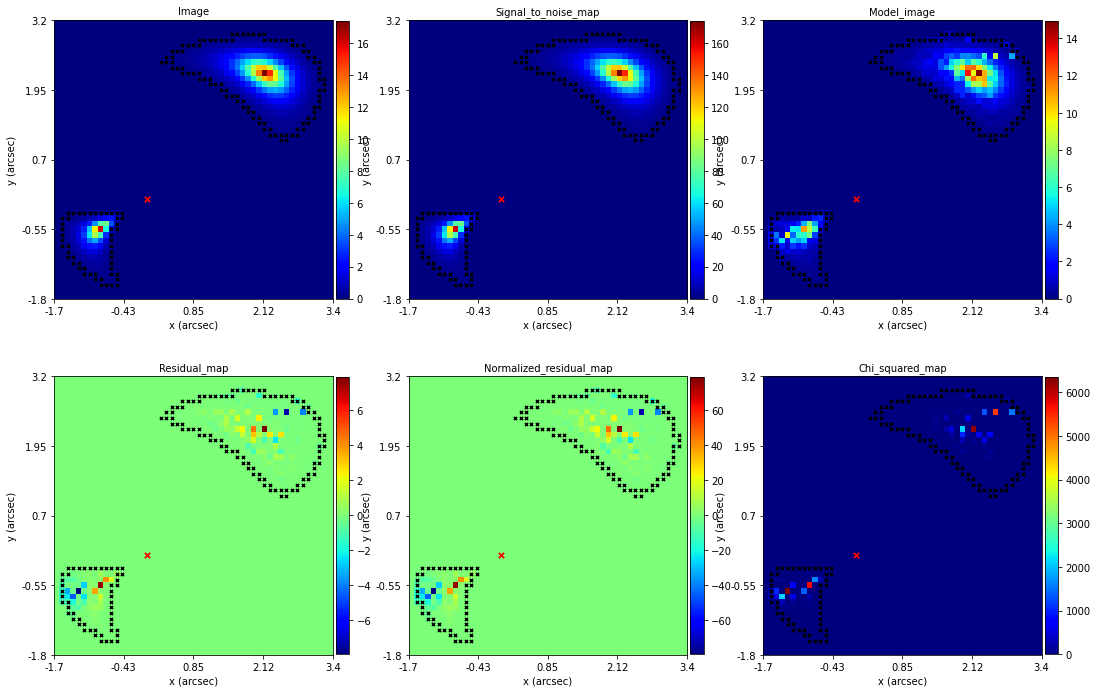

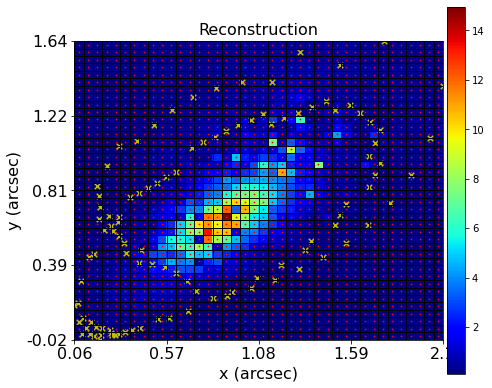

-23929.574033135366
ParsDic:
#------------------------------------#
{'ml': 8.150000014901162, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}


{'ml': 8.150000014901162, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.08
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.02
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio:

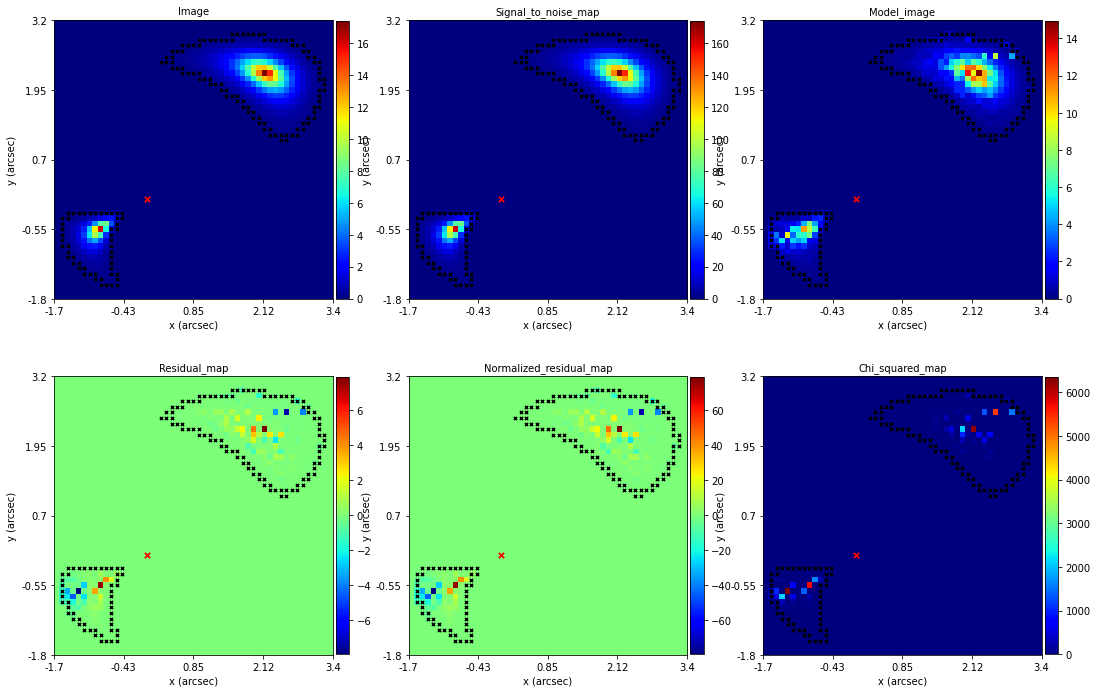

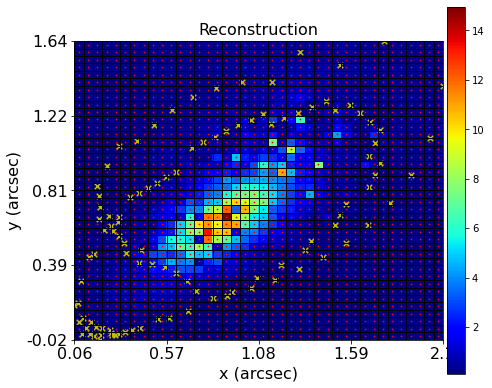

-23929.574033135366
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.0800000149011612, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}


{'ml': 8.15, 'kappa_s': 0.0800000149011612, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.0800000149011612
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.02
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714

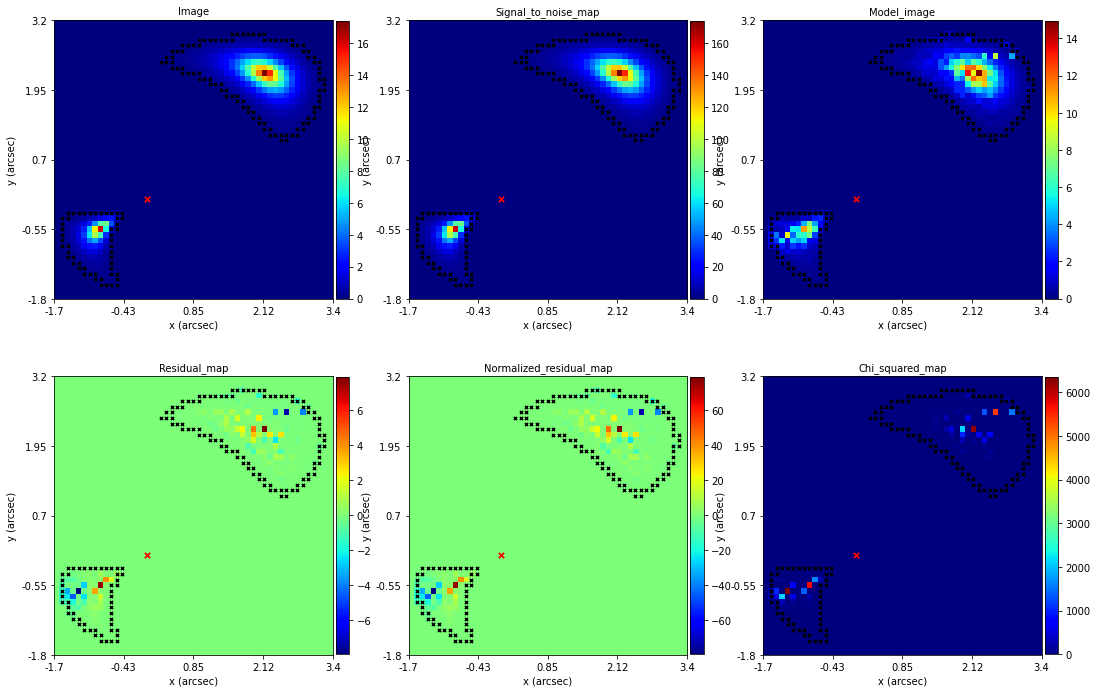

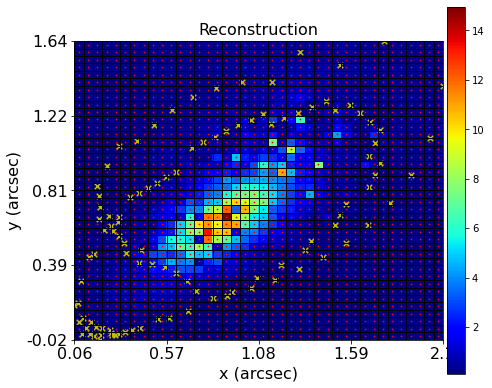

-23929.574033135366
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.7500000149011612, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}


{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.7500000149011612, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285713312577236)
axis_ratio: 0.7500000149011611
phi: 0.0
kappa_s: 0.08
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.02
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285713312577236)
axis_rati

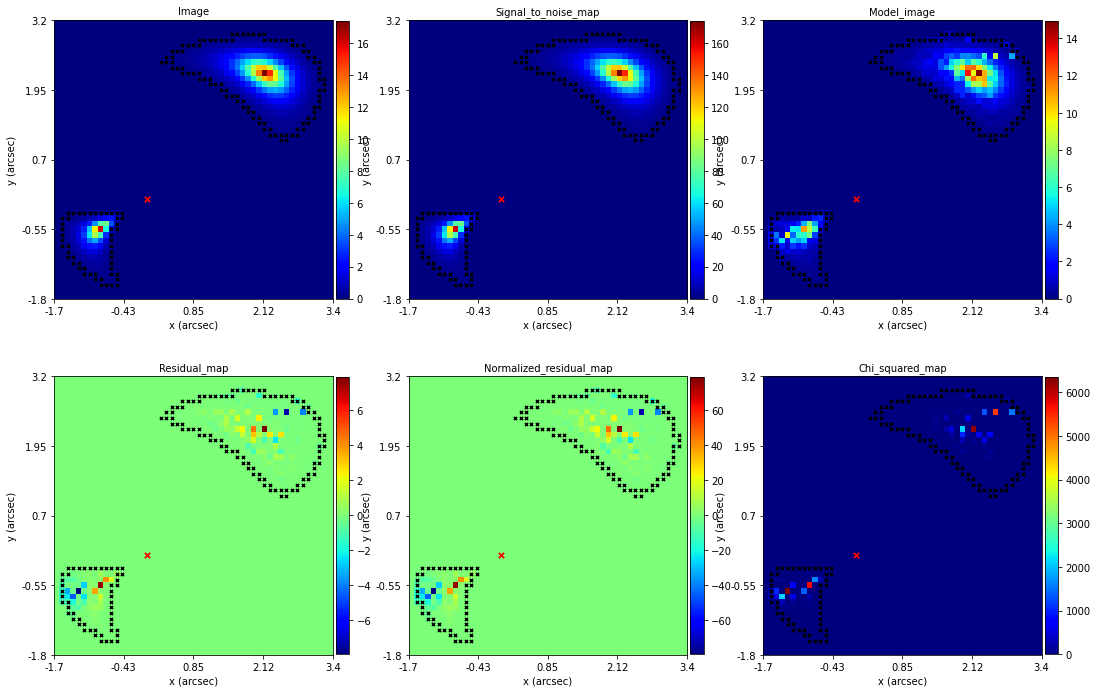

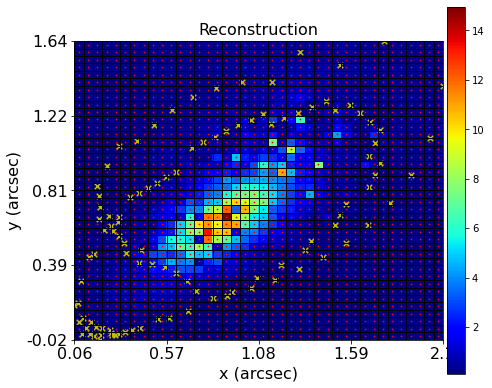

-23929.574033135366
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.000000014901161, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}


{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.000000014901161, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.02}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.08
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.02
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_rati

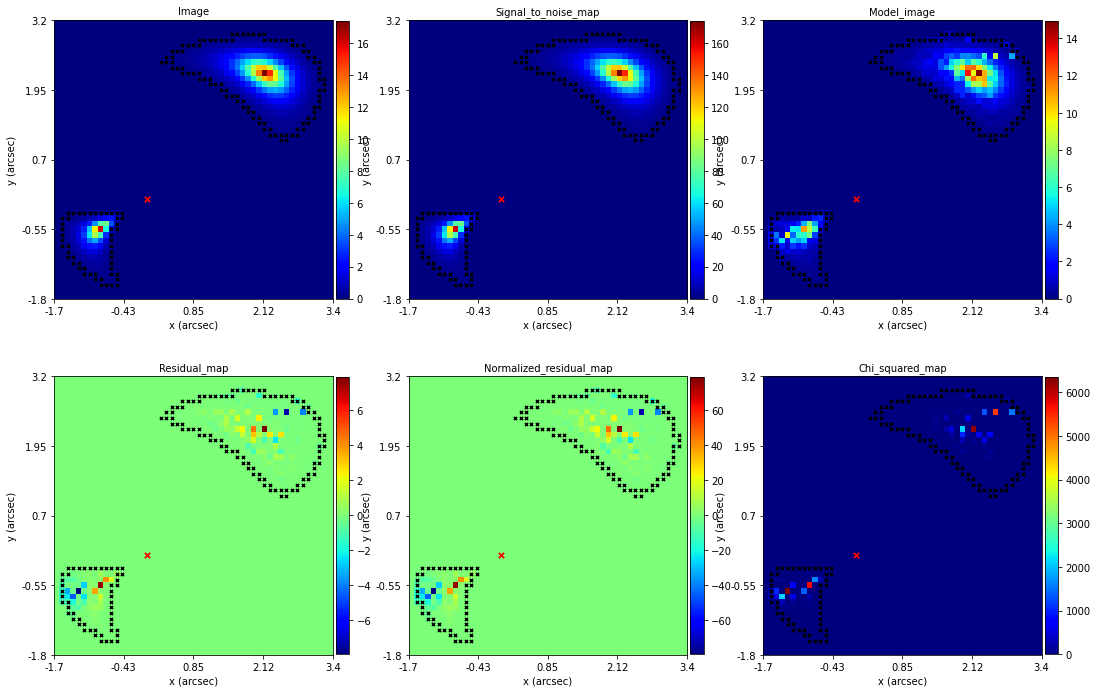

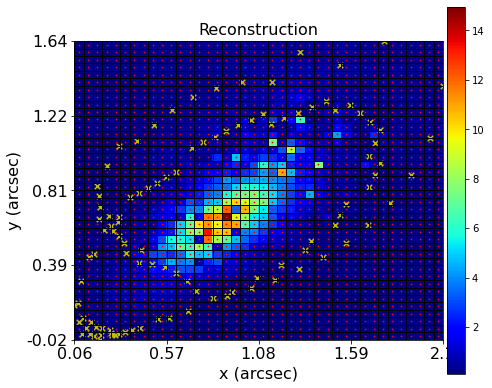

-23929.574033135366
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.010000014901161194, 'phi_shear': 100.0, 'gamma': 1.02}


{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.010000014901161194, 'phi_shear': 100.0, 'gamma': 1.02}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.08
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.02
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_

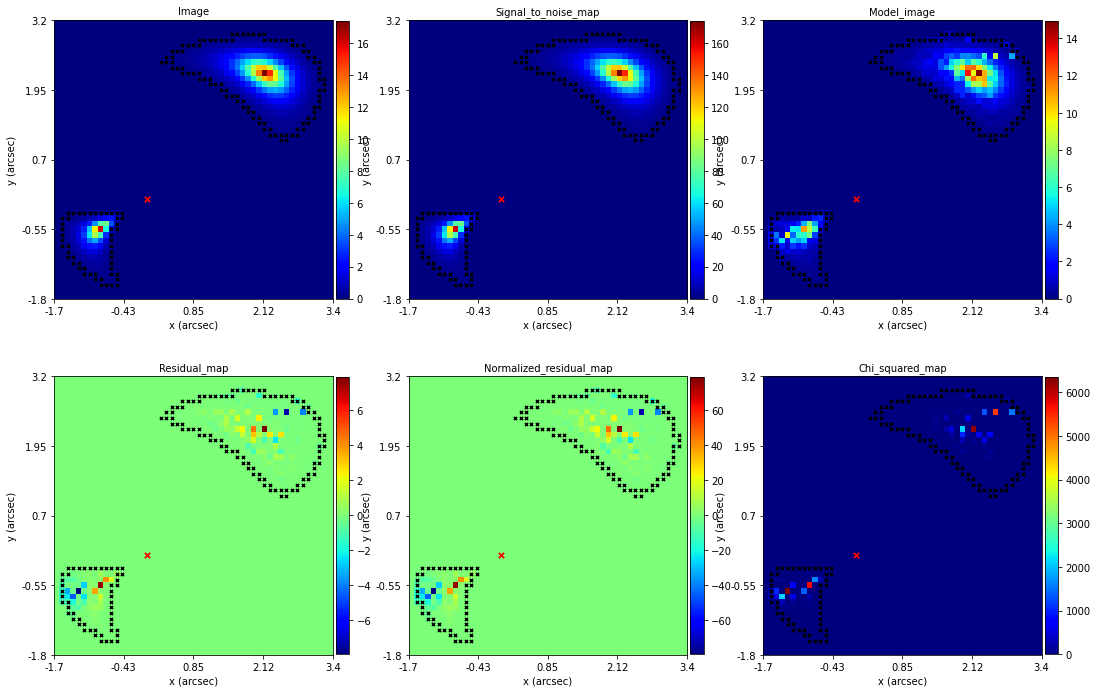

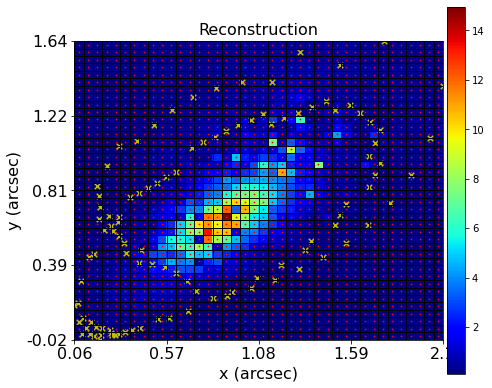

-23929.574033135366
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.00000001490116, 'gamma': 1.02}


{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.00000001490116, 'gamma': 1.02}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.08
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.02
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio:

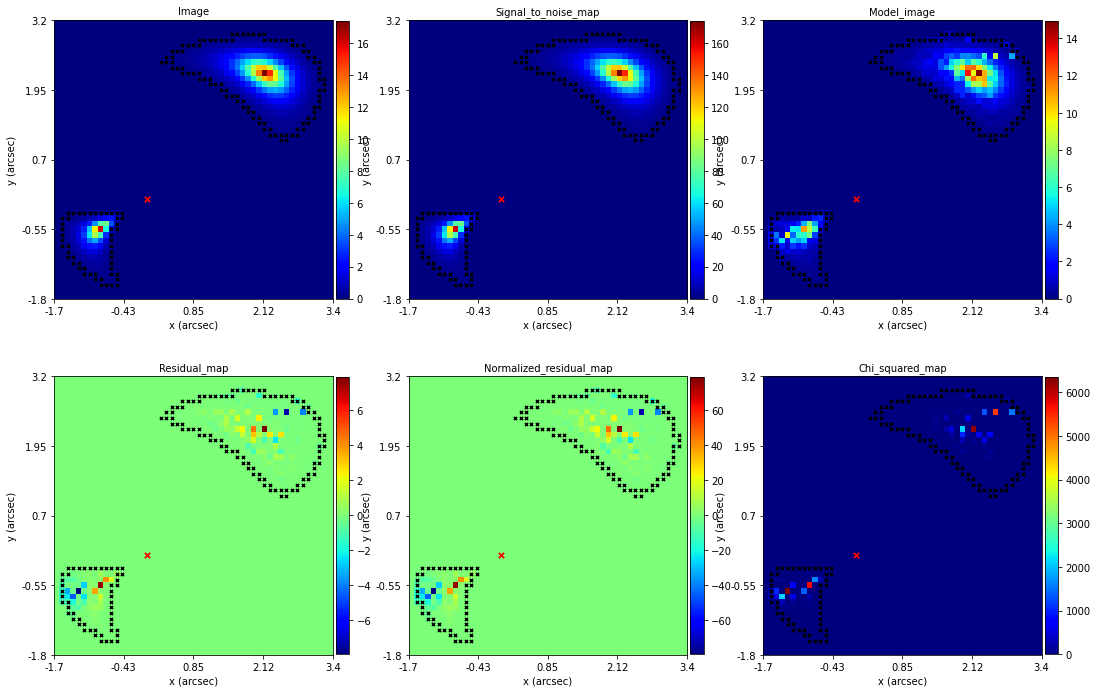

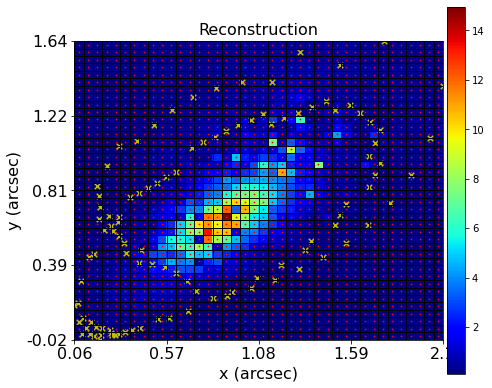

-23929.574033135366
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.0200000149011612}


{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 1.0200000149011612}
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714285)
axis_ratio: 0.7500000000000001
phi: 0.0
kappa_s: 0.08
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -23929.494033135365
Log Normalization -1317.2315249194833
Log Evidence: -24668.70331452552
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0200000149011612
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.14285714285714

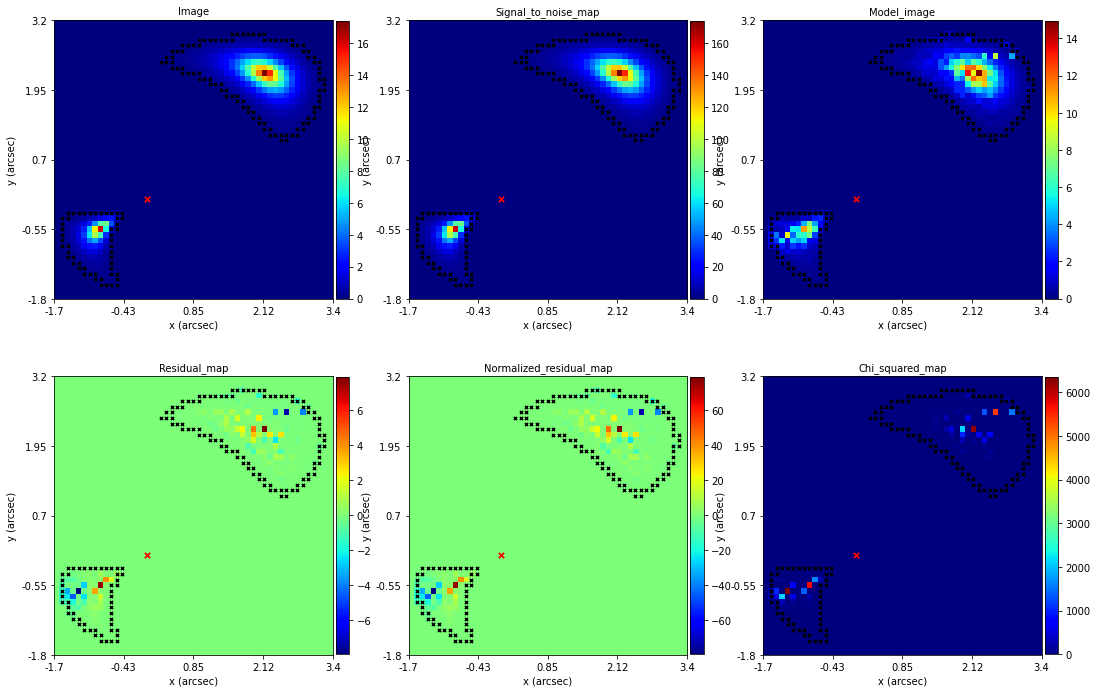

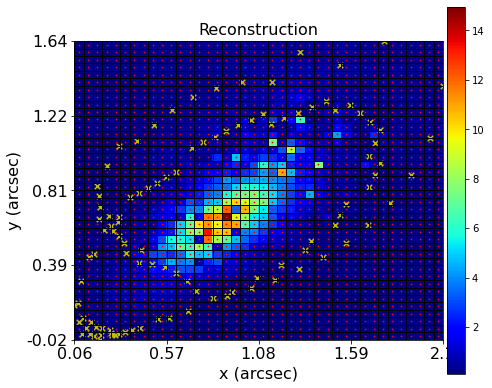

-23929.574033254576
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 2.0300000000000002}


Erro
-inf
ParsDic:
#------------------------------------#
{'ml': 8.150000014901162, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 2.0300000000000002}


Erro
-inf
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.0800000149011612, 'qDM': 0.75, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 2.0300000000000002}


Erro
-inf
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.7500000149011612, 'log_mbh': 8.0, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 2.0300000000000002}


Erro
-inf
ParsDic:
#------------------------------------#
{'ml': 8.15, 'kappa_s': 0.08, 'qDM': 0.75, 'log_mbh': 8.000000014901161, 'mag_shear': 0.01, 'phi_shear': 100.0, 'gamma': 2.0300000000000002}




In [41]:
soln = minimize(nll, np.array([8.15, 0.08, 0.75, 8, 0.01, 100, 1.02]), method="BFGS", )

In [37]:
soln

      fun: -1e+100
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([8.15e+00, 8.00e-02, 7.50e-01, 8.00e+00, 1.00e-02, 1.00e+02,
       2.03e+00])

In [193]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [194]:
a = np.column_stack([points[:,0],points[:,1]])

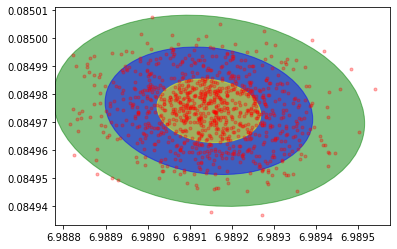

In [195]:
plt.plot(points[:,0], points[:,1], '.r', alpha=0.3)

# Plot a transparent 3 standard deviation covariance ellipse
plot_point_cov(a, nstd=3, alpha=0.5, color='green')
plot_point_cov(a, nstd=2, alpha=0.5, color='blue')
plot_point_cov(a, nstd=1, alpha=0.5, color='yellow')



plt.show()

In [197]:
a = np.column_stack([points[:,2],points[:,4]])

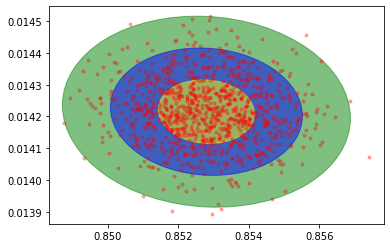

In [198]:
plt.plot(points[:,2], points[:,4], '.r', alpha=0.3)

# Plot a transparent 3 standard deviation covariance ellipse
plot_point_cov(a, nstd=3, alpha=0.5, color='green')
plot_point_cov(a, nstd=2, alpha=0.5, color='blue')
plot_point_cov(a, nstd=1, alpha=0.5, color='yellow')



plt.show()